# 2019 Coronavirus analysis

(Some intro into why this is interesting or important)  
(an overview of what to expect)  
(punchline)

In [20]:
from datetime import date

today = date.today()
print("Last ran:", today)

import warnings
warnings.filterwarnings('ignore')


Last ran: 2020-03-15


Starting off with some theory...


### The SIR epidemic model  (susceptible - infectious - recovered)

<img src="model.png">

A classic form of compartmental modeling, the idea is that a population starts off in a particular bucket (either susceptible, infectious, or recovered) and moves into the next bucket at either the transmission rate or the recovery rate.  

  
If you were to plot out the scenario mathematically, it will look like a logistic curve.


Let :
- **t** represent time   in days
- $B$ represent the transmission of the disease
- **$\gamma$** be the average recovery rate from the disease
- ***S(t)*** be the number of people susceptible but not yet infected with the disease 
- ***I(t)*** be the number of of infectious individuals 
- ***R(t)*** are the number of individuals who recovered/removed and are now immune. Note that this includes people who've died

$\frac{dS}{dt}$ = -$\frac{BSI}{N}$   
$\frac{dI}{dt}$ = $\frac{BSI}{N}$ - $\gamma$I   
$\frac{dR}{dt}$ = $\gamma$I   

R0 = $B$/$\gamma$  
(COVID-2019 R0 is estimated to be between 1.4 to 3.8)

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/eric/miniconda3/envs/geo_test/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


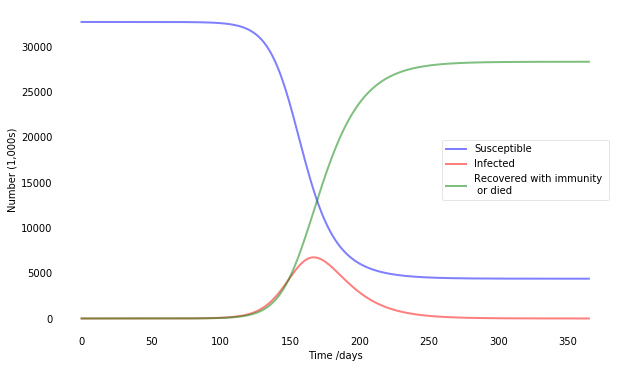

In [3]:
# total population
N = 32700000

# initial number of infected and recovered
I0 = 6
R0 = 0

# everyone else
S0 = N- I0 - R0


#rates (in 1/days)
rnot = 2.32      # estimated to be between 1.4 - 3.8
gamma = 1/14      # time to recovery or death (average of 14 days)
beta = rnot*gamma     # infection rate

# create grid of time points 
days = 365
t = np.linspace(0,days,days)

# differential equations with SIR model
def deriv(y, t, N, beta, gamma):
    S, I, R, = y
    dSdt = -beta*S*I / N
    dIdt = (beta*S*I/N) - gamma*I
    dRdt = gamma*I
    return dSdt, dIdt, dRdt

# create initial conditions vector
y0 = S0, I0, R0

# integration SIR equation over time space
ret = odeint(deriv, y0, t, args=(N,beta,gamma))
S, I, R = ret.T


# Plot the data on three separate curves for S(t), I(t) and R(t)

fig = plt.figure(facecolor='w',figsize=(10, 6))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity \n or died')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1,000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

By plotting out the scenario, we can predict the moment when there is exponential increase in number of people who will be affected by the disease.

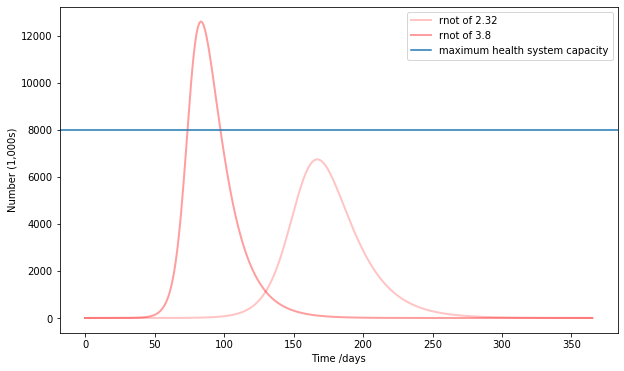

In [4]:
# comparing rnots
rnot_list = [2.32,3.8]
plt.figure(facecolor='w',figsize=(10, 6))

for rnot in rnot_list:
    #rates (in 1/days)
    gamma = 1/14      # time to recovery or death (average of 14 days)
    beta = rnot*gamma     # infection rate

    # create initial conditions vector
    y0 = S0, I0, R0

    # integration SIR equation over time space
    ret = odeint(deriv, y0, t, args=(N,beta,gamma))
    S, I, R = ret.T


    # Plot the data on three separate curves for I(t)
    plt.plot(t, I/1000, 'r', alpha=rnot/10, lw=2, label='rnot of {}'.format(rnot))
    plt.xlabel('Time /days')
    plt.ylabel('Number (1,000s)')
    
    
plt.axhline(y=8000, label='maximum health system capacity')
plt.legend()
plt.show()

something about flattening the curve

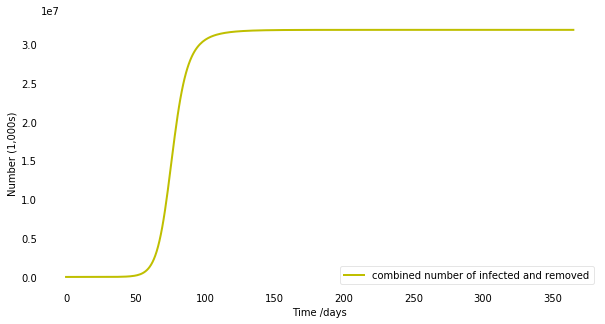

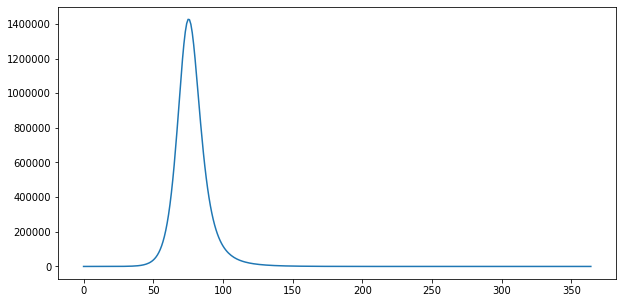

In [5]:
# Plot the data on three separate curves for S(t), I(t) and R(t)

fig = plt.figure(facecolor='w',figsize=(10, 5))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, I+R, 'y', alpha=1, lw=2, label='combined number of infected and removed')
# ax.plot(t, S, 'g', alpha=0.5, lw=2, label='S')
# ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity \n or died')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1,000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
# plt.show()

# taking the derivative of the curve to find inflection point

y = I + R
y_i = np.gradient(y)
plt.figure(figsize=(10,5))
plt.plot(y_i)
plt.show()

  
## Now, looking at the actual data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

%matplotlib inline



In [7]:
df = pd.read_csv('2019-ncov.csv',index_col=0)

# filling missing date by taking average of the previous and preceding dates
for country in df.columns:
    df[country]['2020-01-22'] = (df[country]['2020-01-21'] + df[country]['2020-01-23'])/2

df['Total_no_china'] = df.loc[:,df.columns != 'China'].sum(axis=1)
df['Total'] = df.loc[:,df.columns != 'Total_no_china'].sum(axis=1)


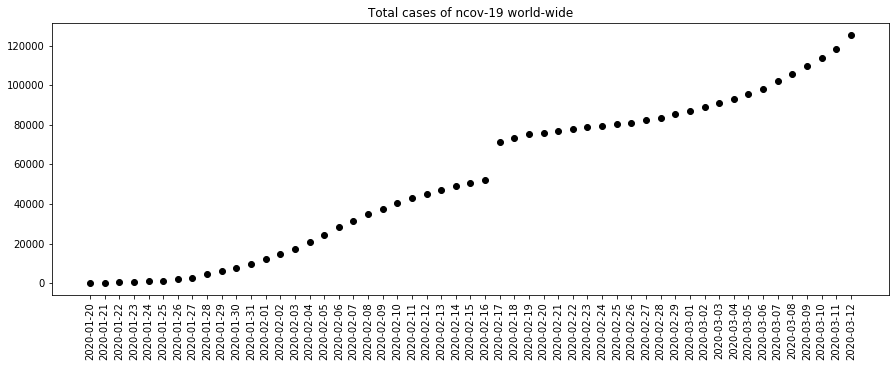

In [8]:
# figure 1
# total cases world wide

plt.figure(figsize=(15,5))

plt.scatter(x=df.index,y=df['Total'], color = 'k')
plt.xticks(rotation=90)
plt.title('Total cases of ncov-19 world-wide')
plt.show()


In [9]:
# 
df.iloc[-1].sort_values(ascending=False).head(n=13)

Total             125083.0
China              80981.0
Total_no_china     44102.0
Italy              12462.0
Iran                9000.0
South Korea         7869.0
France              2269.0
Spain               2140.0
Germany             1567.0
United States        987.0
International        696.0
Switzerland          645.0
Japan                620.0
Name: 2020-03-12, dtype: float64

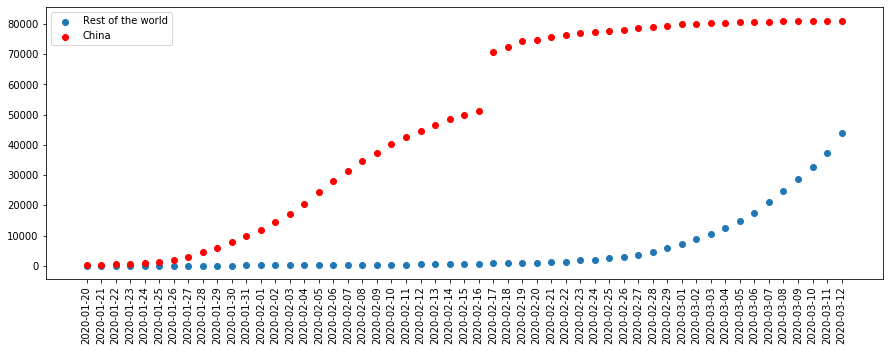

In [10]:
# fig 2
# total cases separating china and the rest of the world

plt.figure(figsize=(15,5))
plt.scatter(x=df.index,y=df['Total_no_china'], label = 'Rest of the world')
plt.scatter(x=df.index,y=df['China'], label='China', color = 'r')
plt.xticks(rotation=90)
plt.legend()
plt.show()

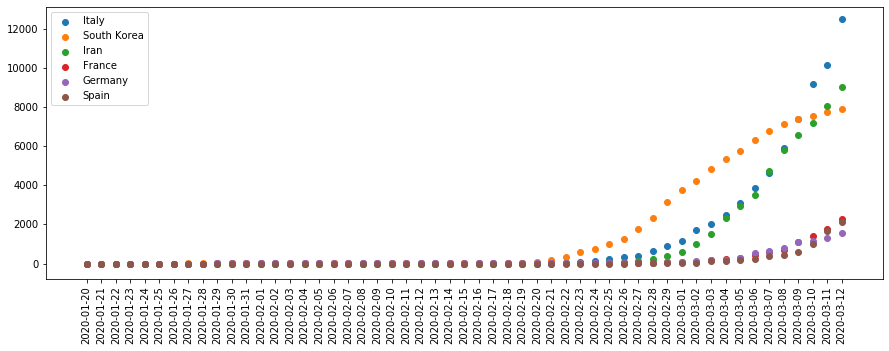

In [11]:
# fig 3
# top six countries (after china) with the highest confirmed cases


plt.figure(figsize=(15,5))

lst = ['Italy','South Korea','Iran','France','Germany','Spain']
df2 = df[[c for c in df.columns if c in lst]]

for country in lst:
    plt.scatter(x=df.index, y=df2[country], label = country)

plt.xticks(rotation=90)
plt.legend()
plt.show()

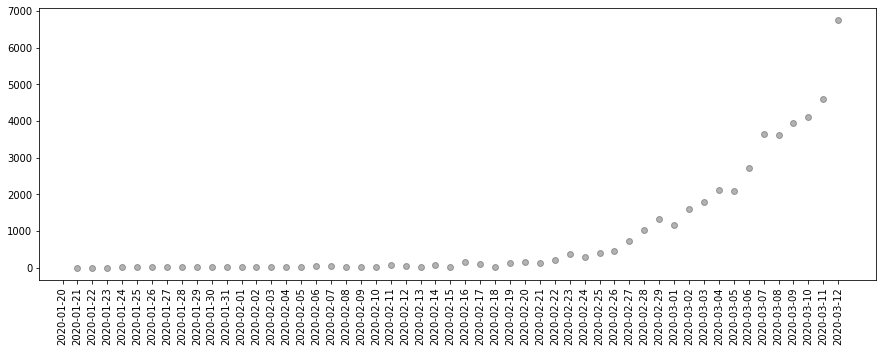

In [12]:
# taking derivatives for china
d1 = df['Total_no_china'].diff()
d2 = d1.diff()

plt.figure(figsize=(15,5))
plt.scatter(y=d1, x=d1.index, c='k', alpha=0.3)
plt.xticks(rotation=90)



# SVR poly kernel on the second derivative
dd1 = d1.reset_index(drop=True)
dd1 = dd1.dropna()
X = np.array(dd1.index).reshape(-1,1)
y = np.array(dd1).reshape(-1,1)

# regression
clf = SVR(kernel='rbf', C=300, gamma=0.1, epsilon=0.1)

# plotting line of best fit
x = np.linspace(0,len(d1)+1,100).reshape(-1,1)
# plt.plot(x,clf.fit(X,y).predict(x))



plt.show()

In [13]:
# getting density data from wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density'
all_tables = pd.read_html(url)

# grabbing relevant table
pop_table = all_tables[0][['Country (or dependent territory)','Area','Population']]

# grabbing relevant columns from table
a = pop_table['Country (or dependent territory)']['Country (or dependent territory)']
b = pop_table['Area']['km2']
c = pop_table['Population']['Population']

# merging into dataframe
frame = {'country':a,'area':b,'population':c}
pop_table_2 = pd.DataFrame(frame)

# removing unwanted data
pop_table_2.drop(pop_table_2.index[[0,1,2,-1,-2]], inplace=True)
pop_table_2.reset_index(inplace=True,drop = True)

# resetting column types
pop_table_2['area'] = pop_table_2['area'].astype(float)
pop_table_2['population'] = pop_table_2['population'].astype(float)

pop_table_2['density'] = pop_table_2['population']/pop_table_2['area']
pop_table_2.sort_values('country', inplace=True)

pop_table_2 = pop_table_2.replace('Faroe Islands (Denmark)', 'Faroe Islands')
pop_table_2 = pop_table_2.replace('French Guiana (France)', 'French Guiana')
pop_table_2 = pop_table_2.replace('Gibraltar (UK)[note 1]', 'Gibraltar')
pop_table_2 = pop_table_2.replace('Guernsey (Crown dependency)', 'Guernsey')
pop_table_2 = pop_table_2.replace('Vatican City', 'Holy See')
pop_table_2 = pop_table_2.replace('Martinique (France)', 'Martinique')
pop_table_2 = pop_table_2.replace('Russia[note 6]', 'Russia')
pop_table_2 = pop_table_2.replace('Saint Martin (France)', 'Saint Martin')
pop_table_2 = pop_table_2.replace('Saint Barthelemy (France)', 'Saint Barthelemy')
pop_table_2 = pop_table_2.replace('Ukraine [note 4]', 'Ukraine')
pop_table_2 = pop_table_2.replace('French Polynesia (France)', 'French Polynesia')
pop_table_2 = pop_table_2.replace('Democratic Republic of the Congo', 'Congo')


# fixing the UK...

uk_countries = ['Wales', 'England','Northern Ireland', 'Scotland']
uk_subset = pop_table_2[pop_table_2['country'].isin(uk_countries)]
uk_row = [['United Kingdom',uk_subset['area'].sum(), uk_subset['population'].sum(), uk_subset['density'].sum()]]
columns = uk_subset.columns
uk_row = pd.DataFrame(uk_row, columns=columns)

pop_table_2 = pop_table_2.append(uk_row, ignore_index=True)
# pop_table_2

In [14]:
# checks if there are countries in the data that is not in wilipedia
pop_countries = [c for c in pop_table_2['country']]
data_countries = [c for c in list(df.columns[:-2])]
[print(c) for c in data_countries if c not in pop_countries]

# want to normalize based on density
dfdf = df[data_countries]
# for country in data_countries:
#     area_ = pop_table_2[pop_table_2['country']==country]['area']
#     density_ = pop_table_2[pop_table_2['country']==country]['density']
#     dfdf[country] = dfdf[country].apply(lambda x: (x / area_))


International


In [15]:
right = pop_table_2[['country','population']]
left = pd.DataFrame(dfdf.iloc[-1])
left.reset_index(inplace=True, drop=False)
left.rename(columns={'index':'country'}, inplace=True)

In [16]:
merged = pd.merge(left,right, how='inner', on='country')
merged['pop_log'] = np.log10(merged['population'])
merged['case_log'] = np.log10(merged['2020-03-12'])

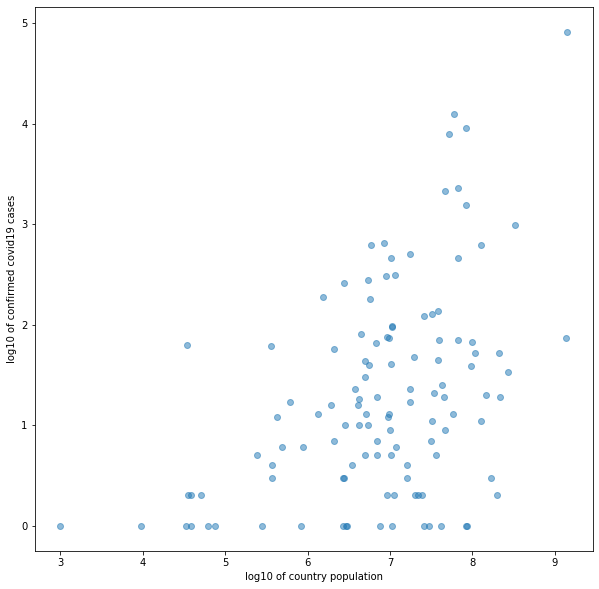

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(x=merged['pop_log'],y=merged['case_log'], alpha = 0.5)
plt.xlabel('log10 of country population')
plt.ylabel('log10 of confirmed covid19 cases')
plt.show()

In [18]:
regions = {
    'china':['China'],
    'western pacific':['South Korea', 'Japan', 'Singapore', 'Malaysia',
                       'Australia','Philippines', 'Vietnam', 'Brunei',
                       'New Zealand', 'Cambodia', 'Mongolia', 'French Polynesia'],
    'european':['Italy', 'France', 'Spain', 'Germany', 'Switzerland', 'Denmark',
                'Netherlands', 'United Kingdom', 'Belgium', 'Austria', 'Norway',
                'Greece', 'Czech Republic', 'Israel', 'San Marino', 'Iceland',
               'Slovenia', 'Romania', 'Poland', 'Ireland', 'Portugal', 'Finland',
                'Georgia', 'Russia', 'Serbia', 'Luxembourg', 'Croatia', 'Latvia',
                'Estonia', 'Hungary', 'Belarus', 'Albania', 'Slovakia', 'Azerbaijan',
                'Bulgaria', 'North Macedonia', 'Cyprus', 'Malta', 'Bosnia and Herzegovina',
               'Moldova', 'Lithuania', 'Andorra', 'Armenia', 'Holy See', 'Liechtenstein',
                'Monaco', 'Turkey', 'Ukraine', 'Faroe Islands', 'Gibraltar', 'Guernsey'],
    'south-east asia':['India', 'Thailand', 'Indonesia', 'Maldives', 'Bangladesh',
                       'Sri Lanka', 'Bhutan', 'Nepal'],
    'eastern mediteranean':['Iran', 'Qatar', 'Bahrain', 'Kuwait', 'United Arab Emirates',
                            'Iraq', 'Egypt', 'Lebanon', 'Saudi Arabia', 'Pakistan', 'Oman',
                            'Afghanistan', 'Tunisia', 'Morocco', 'Jordan', 'Palestine'],
    'americas':['United States', 'Canada', 'Brazil', 'Chile', 'Argentina', 'Ecuador', 
                'Peru', 'Costa Rica', 'Mexico', 'Panama', 'Colombia', 'Dominican Republic',
                'Paraguay', 'Bolivia', 'Honduras', 'Jamaica', 'French Guiana', 'Martinique',
                'Saint Martin', 'Saint Barthelemy'],
    'african':['Algeria', 'South Africa', 'Senegal', 'Burkina Faso', 'Cameroon', 'Nigeria',
               'Ivory Coast', 'Congo', 'Togo']
       
}

china


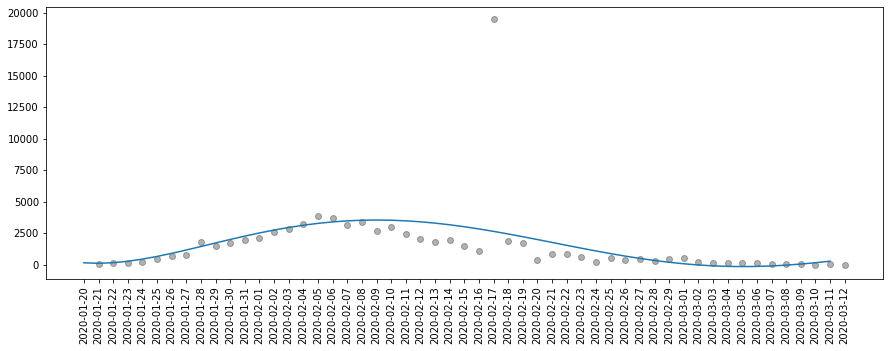

western pacific


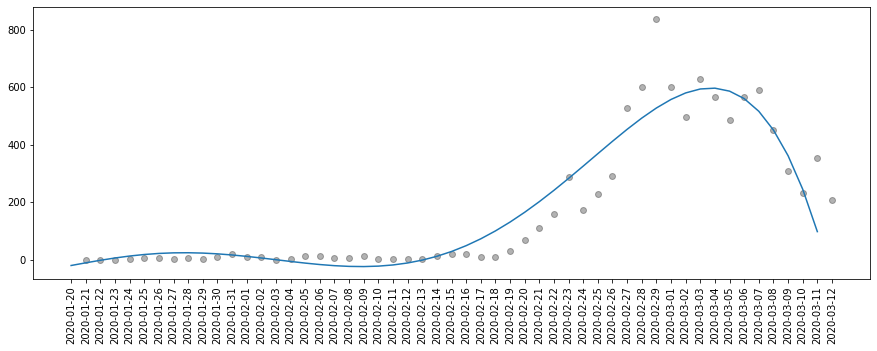

european


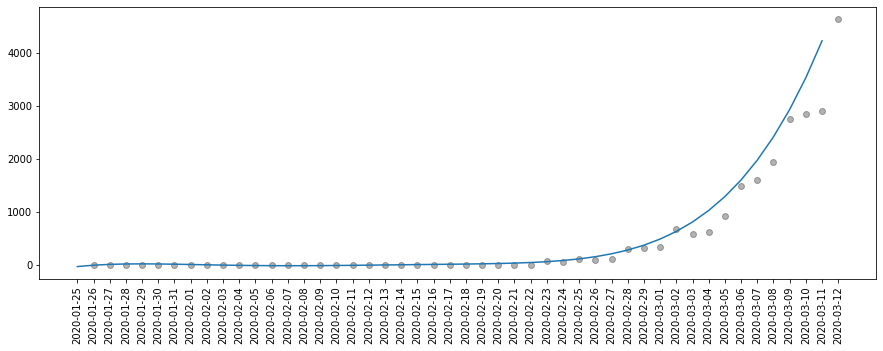

south-east asia


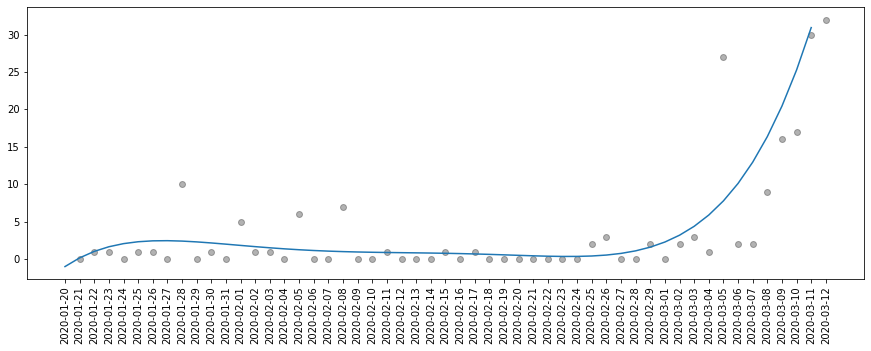

eastern mediteranean


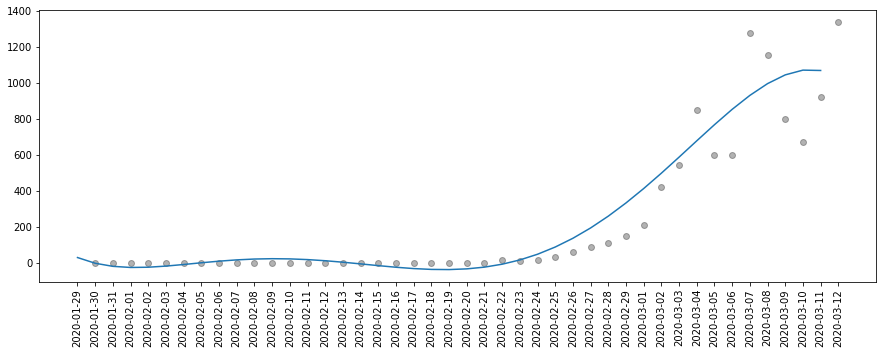

americas


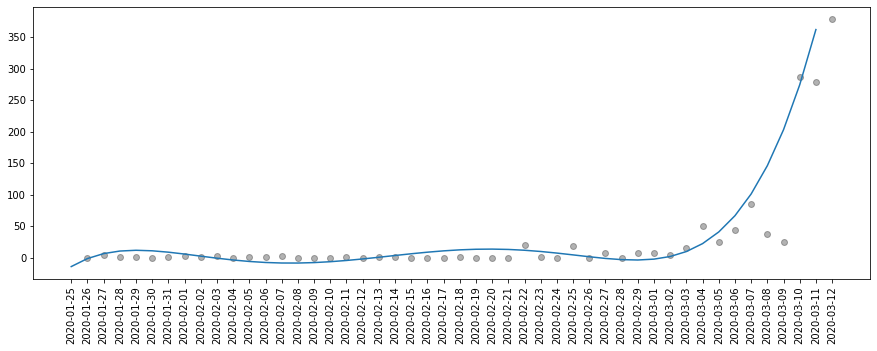

african


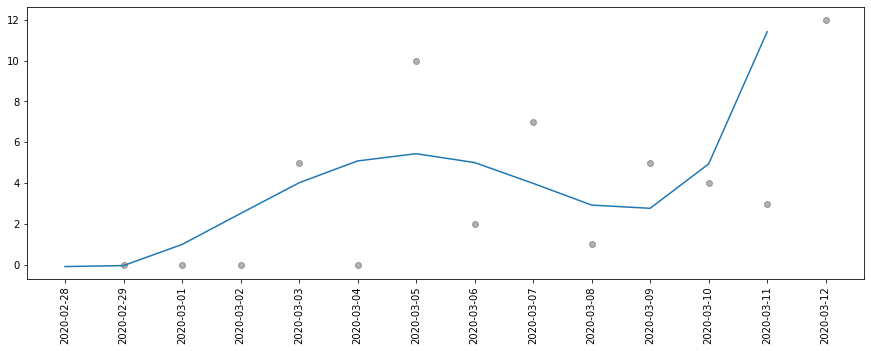

In [23]:
# plotting by region

for region, _ in regions.items():
    df_part = df[regions[region]]
    df_part['total'] = df_part.sum(axis=1)
    df_part = df_part.loc[df_part['total']>1] #checks for at least 10 cases

#     plt.figure(figsize=(15,5))
#     plt.scatter(x=df_part.index ,y=df_part['total'], alpha = 0.5)
#     plt.xticks(rotation=90)
#     plt.show()


    # taking derivative
    d1 = df_part['total'].diff()

    plt.figure(figsize=(15,5))
    plt.scatter(y=d1, x=d1.index, c='k', alpha=0.3)
    plt.xticks(rotation=90)


    dd1 = d1.reset_index(drop=True)
    dd1 = dd1.dropna()
    X = np.array(dd1.index)#.reshape(-1,1)
    y = np.array(dd1)#.reshape(-1,1)


    # plotting line of best fit
    p = np.poly1d(np.polyfit(np.array(dd1.index),np.array(dd1), deg=5))

    plt.plot(p(X))

    print(region)
    plt.show()
#     break

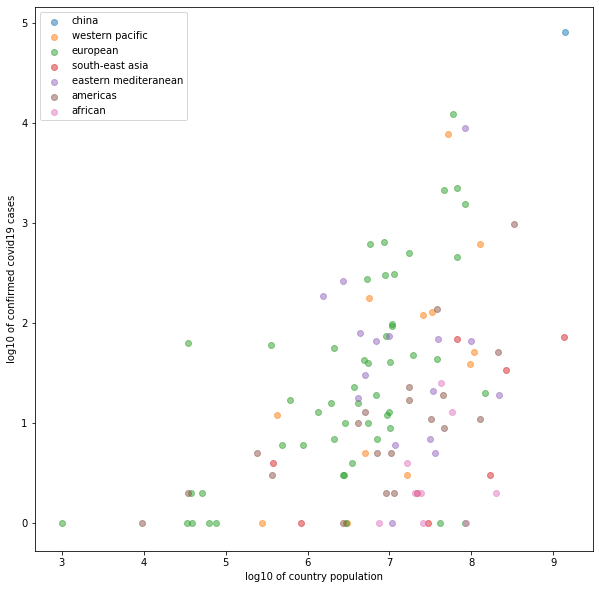

In [20]:
plt.figure(figsize=(10,10))
for region, _ in regions.items():
    m_temp = merged[merged['country'].isin(regions[region])]
    plt.scatter(x=m_temp['pop_log'],y=m_temp['case_log'], alpha = 0.5, label = region)
plt.xlabel('log10 of country population')
plt.ylabel('log10 of confirmed covid19 cases')
plt.legend()
plt.show()

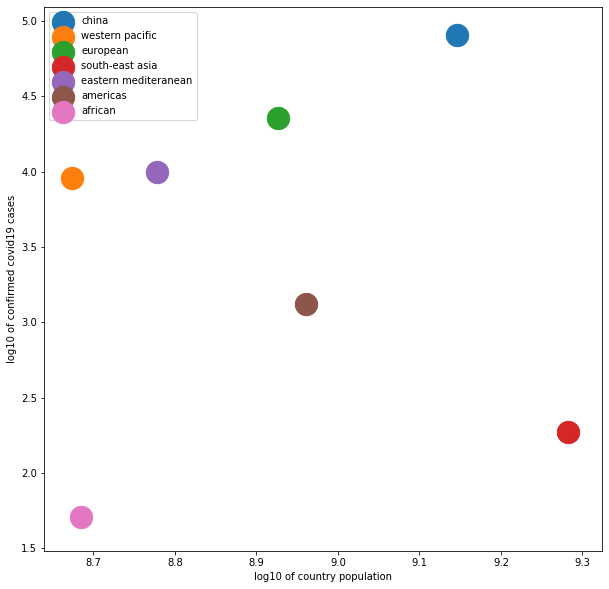

In [21]:
plt.figure(figsize=(10,10))
for region, _ in regions.items():
    m_temp = merged[merged['country'].isin(regions[region])]
    plt.scatter(x=np.log10(m_temp['population'].sum()),y=np.log10(m_temp['2020-03-12'].sum()),
#     plt.scatter(x=m_temp['population'].sum(),y=m_temp['2020-03-12'].sum(),
                alpha = 1, label = region, s=500)
plt.xlabel('log10 of country population')
plt.ylabel('log10 of confirmed covid19 cases')
plt.legend()
plt.show()